# Predict power outages in UK winter storms

This notebook extracts the training or synthetic data for a DNO licence region and season (winter) and aggregates the meteorological variables over the region. Using linear regression coefficients from Manning *et al.* (2025), it predicts the probability of a large power outage event $P(F > F^{95})$ using a logistic regression model with predictors maximum wind gust ($v^X$), maximum deviation from prevailing wind direction at time of maximum wind gust ($d^X$), total 30-day antecedent rainfall $r^{30}$, and season.

In [ ]:
import os
import yaml
from scipy.special import expit
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from regionmask import mask_geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo


with open(os.path.join("..", "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)


regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]
season = config["sfunc"]
local_crs = config["local_crs"]

absmax = lambda x: np.abs(x).max()
agg_funcs = {"vx": "max", "dx": absmax, "r30": "sum"}

Load the DNO license regions and visualise them to make sure.

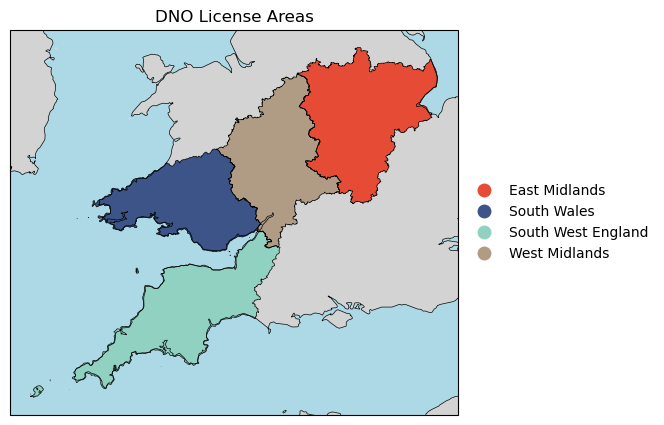

In [26]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["#E64B35", "#4DBBD5", "#00A087", "#3C5488", "#F39B7F", "#8491B4", "#91D1C2", "#DC0000", "#7E6148", "#B09C85"], name='npg')

dno_path = os.path.join("..", "resources", "dno_license_areas.geojson")

dno_regions_uk = gpd.read_file(dno_path)
dno_regions = dno_regions_uk[dno_regions_uk["region"].isin(regions)]
bbox = dno_regions.total_bounds

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(6, 5))

dno_regions.boundary.plot(color="k", ax=ax, linewidth=0.5)
dno_regions.plot("region", ax=ax, categorical=True, legend=True, cmap=cmap,
                 legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "frameon": False})
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

ax.set_title("DNO License Areas");

Load the real and synthetically generated data. Optionally subset by the maximum gust speed. For now, let this depend on whether this subset was used during training.

In [28]:
train = xr.open_dataset(os.path.join("..", "results", "training", "data.nc"))
gener = xr.open_dataset(os.path.join("..", "results", "generated", "netcdf", "data.nc"))

if config["event_subset"]["do"]:
    # subset to events with a max wind gust over a threshold
    train["l2norm"] = np.sqrt(train.sel(field="u10_gust").anomaly**2 + \
                              train.sel(field="v10_v10_gust").anomaly**2)
    mask = train.l2norm.max(dim=["lon", "lat"]) > config["event_subset"]["value"]
    train = train.isel(time=mask)

    gener = np.sqrt(gener.sel(field="u10_gust").anomaly**2 + \
                     gener.sel(field="v10_gust").anomaly**2)
    mask = gener.max(dim=["lon", "lat"]) > config["event_subset"]["value"]
    gener = gener.isel(time=mask)

Decide whether to do the analysis for the training or synthetic data.

In [31]:
dataset = ["train", "generated"][1]

if dataset == "train":
    data = train.copy() #+ medians
else:
    data = gener.copy() #+ medians

From the generated data, we derive the variables of interest as follows.

In [32]:
data["u10"] = data.sel(field="u10_gust").anomaly
data["v10"] = data.sel(field="v10_gust").anomaly
data["r30"] = data.sel(field="r30").anomaly

def direction(
        ds:xr.Dataset, u:str, v:str,
        params={}
        ) -> xr.DataArray:
    u = ds[u]
    v = ds[v]
    direction = (180 + 180 / np.pi * np.arctan2(v, u)) % 360
    return direction


def derive_variables(ds):
    ds["vx"] = np.sqrt(ds.u10**2 + ds.v10**2)
    ds["dx"] = direction(ds, "u10", "v10")
    return ds

data = derive_variables(data)
data["dx"] = data["dx"].__abs__()

# assign units to variables
data.vx.attrs["units"] = "m/s"
data.dx.attrs["units"] = "°"
data.r30.attrs["units"] = "mm"

# assign long names to variables
data.vx.attrs["long_name"] = "10m wind speed anomaly"
data.dx.attrs["long_name"] = "10m wind direction anomaly"
data.r30.attrs["long_name"] = "30-day accumulated precipitation anomaly"

Visualise these for a random time over the DNO licence region of interest (`region_of_interest`).

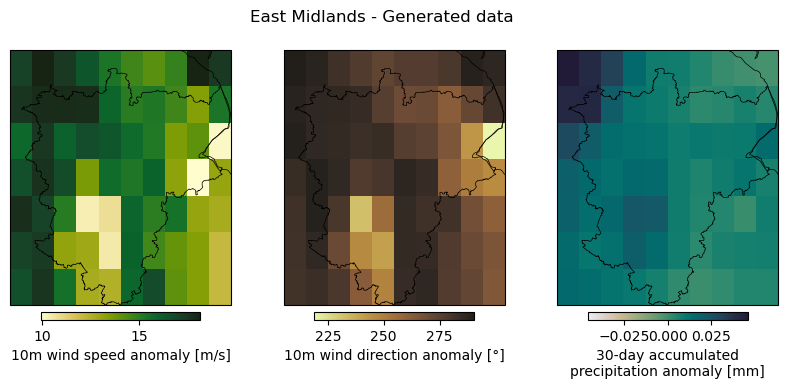

In [ ]:
# %% crop to license area
t = 100

data_t = data.isel(time=t)

dno_region = dno_regions[dno_regions["region"] == region_of_interest]
dno_buffered = dno_region.to_crs(27700).buffer(1500).to_crs(4326)
dno_bbox = dno_buffered.total_bounds

lon_mask = (data_t.lon >= dno_bbox[0]) & (data_t.lon <= dno_bbox[2])
lat_mask = (data_t.lat >= dno_bbox[1]) & (data_t.lat <= dno_bbox[3])
data_region = data_t.isel(lon=lon_mask, lat=lat_mask)

fig, axs = plt.subplots(1, 3, figsize=(10, 4), subplot_kw={"projection": ccrs.PlateCarree()})

cbar_kws = {"shrink": 0.7, "pad": 0.02, "orientation": "horizontal"}

data_region.vx.plot(ax=axs[0], cmap=cmo.speed, cbar_kwargs=cbar_kws)
data_region.dx.plot(ax=axs[1], cmap=cmo.turbid, cbar_kwargs=cbar_kws)
data_region.r30.plot(ax=axs[2], cmap=cmo.rain, cbar_kwargs=cbar_kws)

for ax in axs:
    dno_region.boundary.plot(color="k", ax=ax, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_title("")

fig.suptitle(f"{region_of_interest} - {dataset.capitalize()} event", fontsize=12);

We need to extract values intersecting the DNO licence region, and aggregate them (mean or max) over the region.

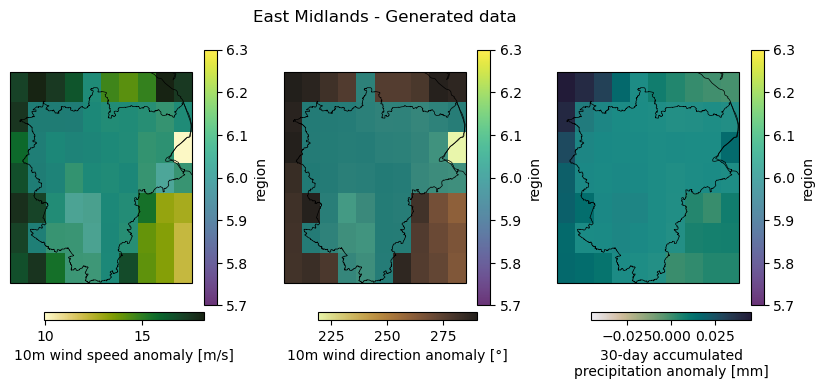

In [ ]:
# %% aggregate over license area
lon = data_region.lon.values
lat = data_region.lat.values

dno_mask = mask_geopandas(dno_buffered, lon, lat)
data_region["dno_mask"] = dno_mask

fig, axs = plt.subplots(1, 3, figsize=(10, 4), subplot_kw={"projection": ccrs.PlateCarree()})

cbar_kws = {"shrink": 0.7, "pad": 0.02, "orientation": "horizontal"}

data_region.vx.plot(ax=axs[0], cmap=cmo.speed, cbar_kwargs=cbar_kws)
data_region.dx.plot(ax=axs[1], cmap=cmo.turbid, cbar_kwargs=cbar_kws)
data_region.r30.plot(ax=axs[2], cmap=cmo.rain, cbar_kwargs=cbar_kws)

for ax in axs:
    dno_region.boundary.plot(color="k", ax=ax, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    data_region.dno_mask.plot(alpha=0.8, ax=ax)
    ax.set_title("")

fig.suptitle(f"{region_of_interest} - {dataset.capitalize()} event", fontsize=12);

/Users/alison/mamba/envs/hazGAN/lib/python3.13/site-packages/xarray/structure/concat.py:547: UserWarning: No index created for dimension dno_mask because variable dno_mask is not a coordinate. To create an index for dno_mask, please first call `.set_coords('dno_mask')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


(array([  2.,  12.,  35.,  57.,  73.,  95., 111., 121., 121., 142., 126.,
        125., 106.,  97.,  68.,  48.,  30.,  32.,  22.,   7.]),
 array([-0.0394228 , -0.03451491, -0.02960703, -0.02469914, -0.01979126,
        -0.01488338, -0.00997549, -0.00506761, -0.00015973,  0.00474816,
         0.00965604,  0.01456392,  0.01947181,  0.02437969,  0.02928758,
         0.03419546,  0.03910334,  0.04401123,  0.04891911,  0.05382699,
         0.05873488]),
 <BarContainer object of 20 artists>)

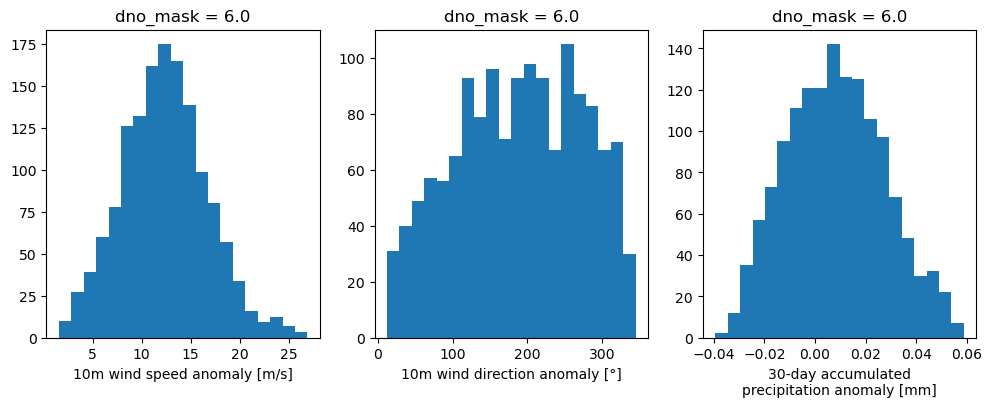

In [56]:
data["dno_mask"] = mask_geopandas(dno_buffered, data.lon, data.lat)
data_agg = data.groupby("dno_mask").reduce(getattr(np, "mean"))

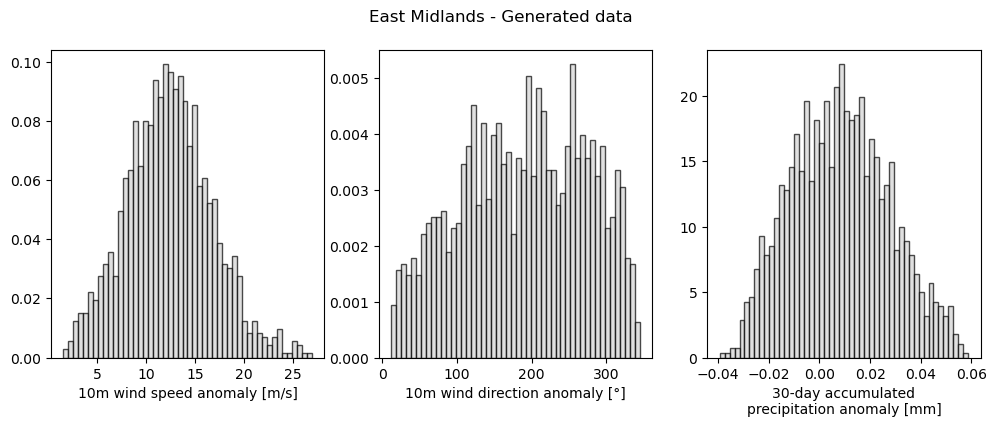

In [ ]:
hist_kws = {"density": True, "alpha": 0.7, "bins": 50,  "color": "lightgrey", "edgecolor": "k"}

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

data_agg.vx.plot.hist(ax=axs[0], **hist_kws)
data_agg.dx.plot.hist(ax=axs[1], **hist_kws)
data_agg.r30.plot.hist(ax=axs[2], **hist_kws);

for ax in axs:
    ax.set_title("")

fig.suptitle(f"{region_of_interest} - {dataset.capitalize()} events", fontsize=12);

Finally, we can use the regression coefficients from Manning *et al.* (2025) to predict the probability of a large power outage event $P(F > F^{95})$.

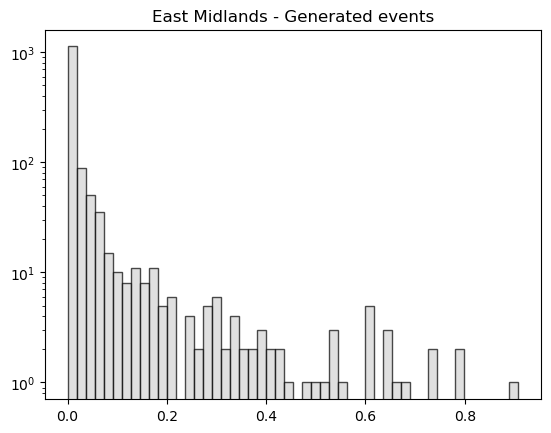

In [ ]:
# %% load the coefs
coefs = pd.read_csv(os.path.join("..", "resources/E_Mid_All_Variable_Model_coefficients_wind-thresh=20.csv"))

X = np.hstack([
    np.ones(data_agg.vx.shape).reshape(-1, 1),
    data_agg.vx.values.reshape(-1, 1),
    data_agg.r30.values.reshape(-1, 1),
    data_agg.dx.values.reshape(-1, 1),
    np.zeros(data_agg.vx.shape).reshape(-1, 1),
    np.zeros(data_agg.vx.shape).reshape(-1, 1),
    np.zeros(data_agg.vx.shape).reshape(-1, 1)
    ])

probs = expit(np.dot(X, coefs["Coefficients"].values))
data_agg["outage_prob"] = (("time"), probs)

hist_kws = {"density": False, "alpha": 0.7, "bins": 50,  "color": "lightgrey", "edgecolor": "k"}

plt.hist(probs, **hist_kws)
plt.title(f"{region_of_interest} - {dataset.capitalize()} events", fontsize=12)
plt.yscale("log")

Text(0.5, 1.0, '')

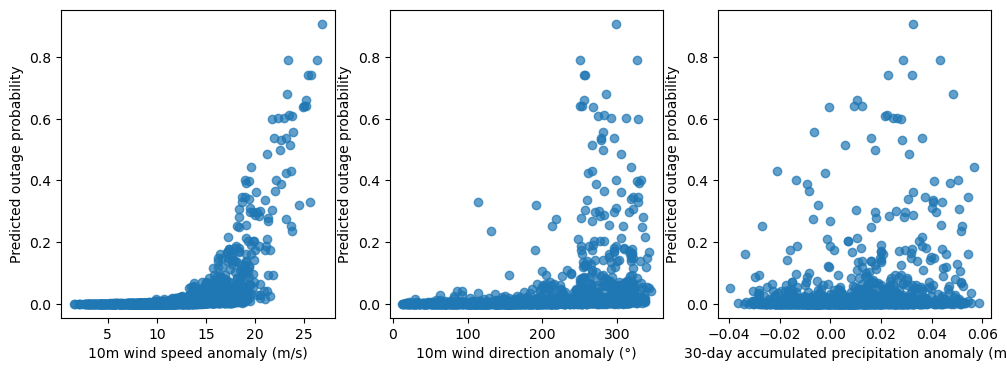

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

ax = axs[0]
ax.scatter(data_agg.vx, data_agg.outage_prob, alpha=0.7)
ax.set_xlabel(data_agg.vx.long_name + f" ({data_agg.vx.units})")
ax.set_ylabel("Predicted outage probability")
ax.set_title("")

ax = axs[1]
ax.scatter(data_agg.dx, data_agg.outage_prob, alpha=0.7)
ax.set_xlabel(data_agg.dx.long_name + f" ({data_agg.dx.units})")
ax.set_ylabel("Predicted outage probability")
ax.set_title("")

ax = axs[2]
ax.scatter(data_agg.r30, data_agg.outage_prob, alpha=0.7)
ax.set_xlabel(data_agg.r30.long_name + f" ({data_agg.r30.units})")
ax.set_ylabel("Predicted outage probability")
ax.set_title("")

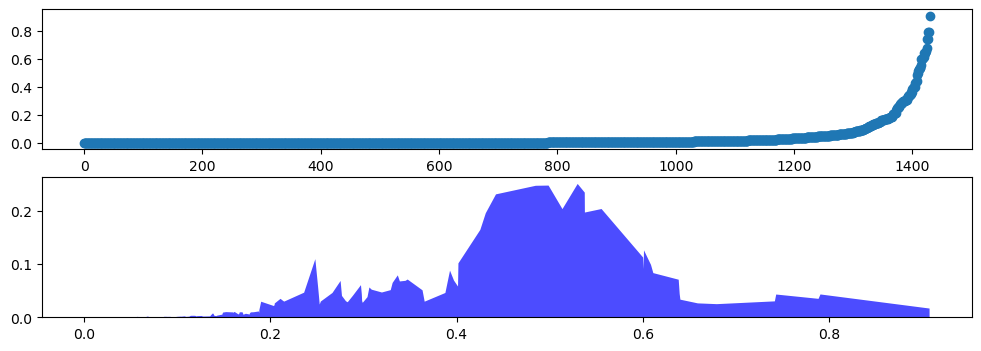

In [109]:
def standardize(series):
    return ((series - series.mean()) / series.std()).values.squeeze()


idx = np.argsort(data_agg.outage_prob).values.tolist()
data_sorted = data_agg.isel(time=idx)

fig, axs = plt.subplots(2, 1, figsize=(12, 4))

ax = axs[0]
ax.scatter(data_sorted.time, data_sorted.outage_prob[idx])

ax = axs[1]
from scipy.ndimage import uniform_filter1d
from scipy.special import expit  # logistic function

window = 50

# Your logistic regression parameters

coef_vx = coefs.set_index("Variables").loc["Wind", "Coefficients"].item()
coef_dx = coefs.set_index("Variables").loc["Direction", "Coefficients"].item()
coef_r30 = coefs.set_index("Variables").loc["Rainfall", "Coefficients"].item()
intercept = coefs.set_index("Variables").loc["Intercept", "Coefficients"].item()

vx_std = standardize(data_sorted.vx)
dx_std = standardize(data_sorted.dx)
r30_std = standardize(data_sorted.r30)

# Calculate logit contributions
vx_logit = coef_vx * vx_std
dx_logit = coef_dx * dx_std
r30_logit = coef_r30 * r30_std

# Smooth the contributions
vx_smooth = uniform_filter1d(vx_logit, window)
dx_smooth = uniform_filter1d(dx_logit, window)
r30_smooth = uniform_filter1d(r30_logit, window)

# Convert to probability scale contributions
# The total logit is: intercept + vx_logit + dx_logit + r30_logit
total_logit = intercept + vx_smooth + dx_smooth + r30_smooth
predicted_prob = expit(total_logit)

# Calculate marginal contributions in probability space
# This shows how much each variable contributes to the final probability
baseline_prob = expit(intercept)
vx_contrib = expit(intercept + vx_smooth) - baseline_prob
dx_contrib = expit(intercept + vx_smooth + dx_smooth) - expit(intercept + vx_smooth)
r30_contrib = expit(intercept + vx_smooth + dx_smooth + r30_smooth) - expit(intercept + vx_smooth + dx_smooth)

ax.stackplot(data_sorted.outage_prob,
             vx_contrib, dx_contrib, r30_contrib,
             labels=[f"{data_sorted.vx.long_name} (β={coef_vx:.3f})",
                     f"{data_sorted.dx.long_name} (β={coef_dx:.3f})",
                     f"{data_sorted.r30.long_name} (β={coef_r30:.3f})"],
             colors=["green", "orange", "blue"], alpha=0.7)



In [78]:
idx = np.argsort(data_agg.outage_prob).values.tolist()
idx

[10,
 1317,
 1037,
 67,
 184,
 268,
 109,
 1043,
 902,
 710,
 30,
 293,
 1136,
 353,
 1423,
 848,
 491,
 1153,
 1274,
 84,
 1089,
 742,
 365,
 1111,
 214,
 1345,
 1068,
 1263,
 274,
 620,
 451,
 306,
 465,
 1213,
 893,
 1284,
 1202,
 1306,
 1261,
 1359,
 1070,
 639,
 1053,
 887,
 758,
 498,
 1174,
 775,
 1192,
 352,
 846,
 355,
 819,
 683,
 1121,
 416,
 288,
 165,
 271,
 883,
 918,
 533,
 374,
 1098,
 939,
 81,
 1063,
 1370,
 666,
 640,
 134,
 825,
 970,
 934,
 971,
 299,
 504,
 98,
 687,
 547,
 369,
 588,
 1285,
 153,
 1199,
 1091,
 590,
 458,
 508,
 96,
 908,
 1390,
 878,
 884,
 317,
 906,
 246,
 784,
 812,
 516,
 440,
 975,
 768,
 905,
 296,
 622,
 26,
 1011,
 948,
 543,
 994,
 1325,
 690,
 1292,
 284,
 1332,
 591,
 431,
 1156,
 187,
 570,
 1200,
 457,
 745,
 92,
 586,
 1223,
 1364,
 1080,
 1369,
 958,
 1250,
 423,
 1052,
 441,
 379,
 894,
 168,
 954,
 174,
 1129,
 197,
 982,
 925,
 881,
 331,
 506,
 425,
 154,
 1329,
 103,
 302,
 1334,
 1411,
 1299,
 111,
 366,
 668,
 1096,
 769,
 